# 旅行セールスマン問題に対するQAOA

このチュートリアルでは、5都市の旅行セールスマン問題（TSP）を量子近似最適化アルゴリズム（QAOA）を用いて解く方法を示します。Quri-Partsをシミュレータとして利用し、アルゴリズムの実装とテストを行います。

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
from collections import defaultdict
from typing import Sequence

import jijmodeling as jm
import matplotlib.pyplot as plt
import numpy as np
import ommx.v1
from quri_parts.core.state import quantum_state, apply_circuit
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from scipy import optimize as opt

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.quri_parts import QuriPartsTranspiler

## JijModeling を用いた定式化
まず、JijModelingを使用して旅行セールスマン問題（TSP）を定式化します。都市の集合を ${0, 1, \dots, N-1}$ とします。

意思決定変数の数を減らすために、問題を少し定式化し直します。始点の都市を都市 $N-1$ に固定し、残りの都市 $0, 1, \dots, N-2$ の訪問順序を決定することに焦点を当てます。

この問題設定では、都市 $N-1$ を出発点および終着点とし、他のすべての都市をちょうど一度ずつ訪れる最短経路を求めることが目標です。

変数の定義は以下の通りです：

- $N$：都市の総数。
- $d_{u,v}$：都市 $u$ から都市 $v$ への距離。
- $x_{u,j}$：都市 $u$ が巡回路の $j$ 番目に訪問される場合に1となるバイナリ変数。ここで、$u = 0, 1, \dots, N-2$ および $j = 0, 1, \dots, N-2$。

In [3]:
def create_tsp_problem():
  N = jm.Placeholder("N")
  D = jm.Placeholder("d", ndim=2)
  x = jm.BinaryVar("x", shape=(N-1, N-1))
  t = jm.Element("t", belong_to=N-2)
  j = jm.Element("j", belong_to=N-1)
  u = jm.Element("u", belong_to=N-1)
  v = jm.Element("v", belong_to=N-1)

  problem = jm.Problem("TSP")

  problem += jm.Constraint("Visit all cities at least once", jm.sum(j ,x[u,j]) == 1, forall=u)
  problem += jm.Constraint("Visit one city at each time", jm.sum(u, x[u,j]) == 1, forall=j)

  problem += jm.sum(u,  D[N-1][u]*(x[u][0] + x[u][N-2])) + jm.sum(t,jm.sum(u, jm.sum(v, D[u][v]*x[u][t]*x[v][t+1])))
  return problem

problem = create_tsp_problem()
problem

## インスタンスデータの準備

次に、TSP問題のインスタンスデータを準備します。これには、各都市間の距離を定義することが含まれます。これらの距離は、コスト関数や制約条件をモデル化する上で不可欠な要素です。

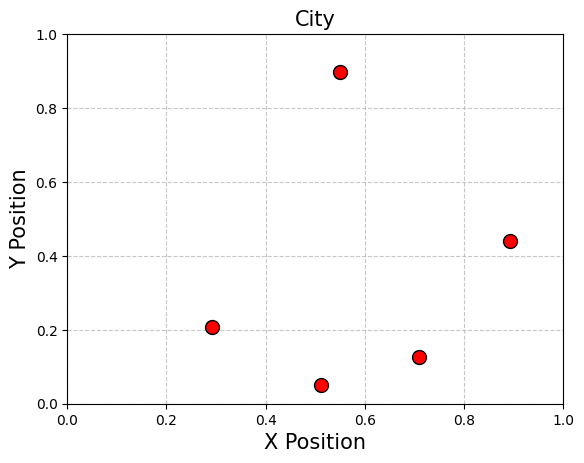

In [4]:
N = 5
np.random.seed(3)

num_qubits = (N - 1)**2

x_pos = np.random.rand(N)
y_pos = np.random.rand(N)

plt.scatter(x_pos, y_pos, c='red', s=100, edgecolors='k', zorder=3)
plt.title(f"City", fontsize=15)
plt.xlabel("X Position", fontsize=15)
plt.ylabel("Y Position", fontsize=15)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)

In [5]:
d = [[0]*N for _ in range(N)]
for i in range(N):
  for j in range(N):
    d[i][j] = np.sqrt((x_pos[i] - x_pos[j])**2 + (y_pos[i] - y_pos[j])**2)

instance_data = {"N": N, "d": d}

num_qubits = (N - 1)**2

## コンパイル済みインスタンスの作成
TSPを標準的な量子近似最適化アルゴリズム（QAOA）を用いて解きます。QAOAの概要については、別のチュートリアル[1]で紹介されているので、詳細はそちらをご参照ください。

まず、定式化したTSP問題とインスタンスデータから、中間表現としてのモデルを生成するために、`JijModeling.Interpreter`と`ommx.Instance`を使用します。

In [6]:
compiled_instance = jm.Interpreter(instance_data).eval_problem(problem)

## Qamomileを用いたQAOA回路とハミルトニアンの生成
次に、`QAOAConverter`を利用します。制約項に対する重みを設定し、QAOAの回路とハミルトニアンを生成します。本チュートリアルでは、$p=4$ を使用します。ただし、QAOAやQuantum Alternating Operator Ansatzの性能は$p$の値によって大きく異なることがあるため、興味のある読者は$p$の値を大きくして試してみることをお勧めします（ただし、計算時間が増加する点に注意してください）。

In [7]:
p = 4
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode(multipliers={"Visit all cities at least once": 42, "Visit one city at each time": 42})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## QAOA 回路の可視化

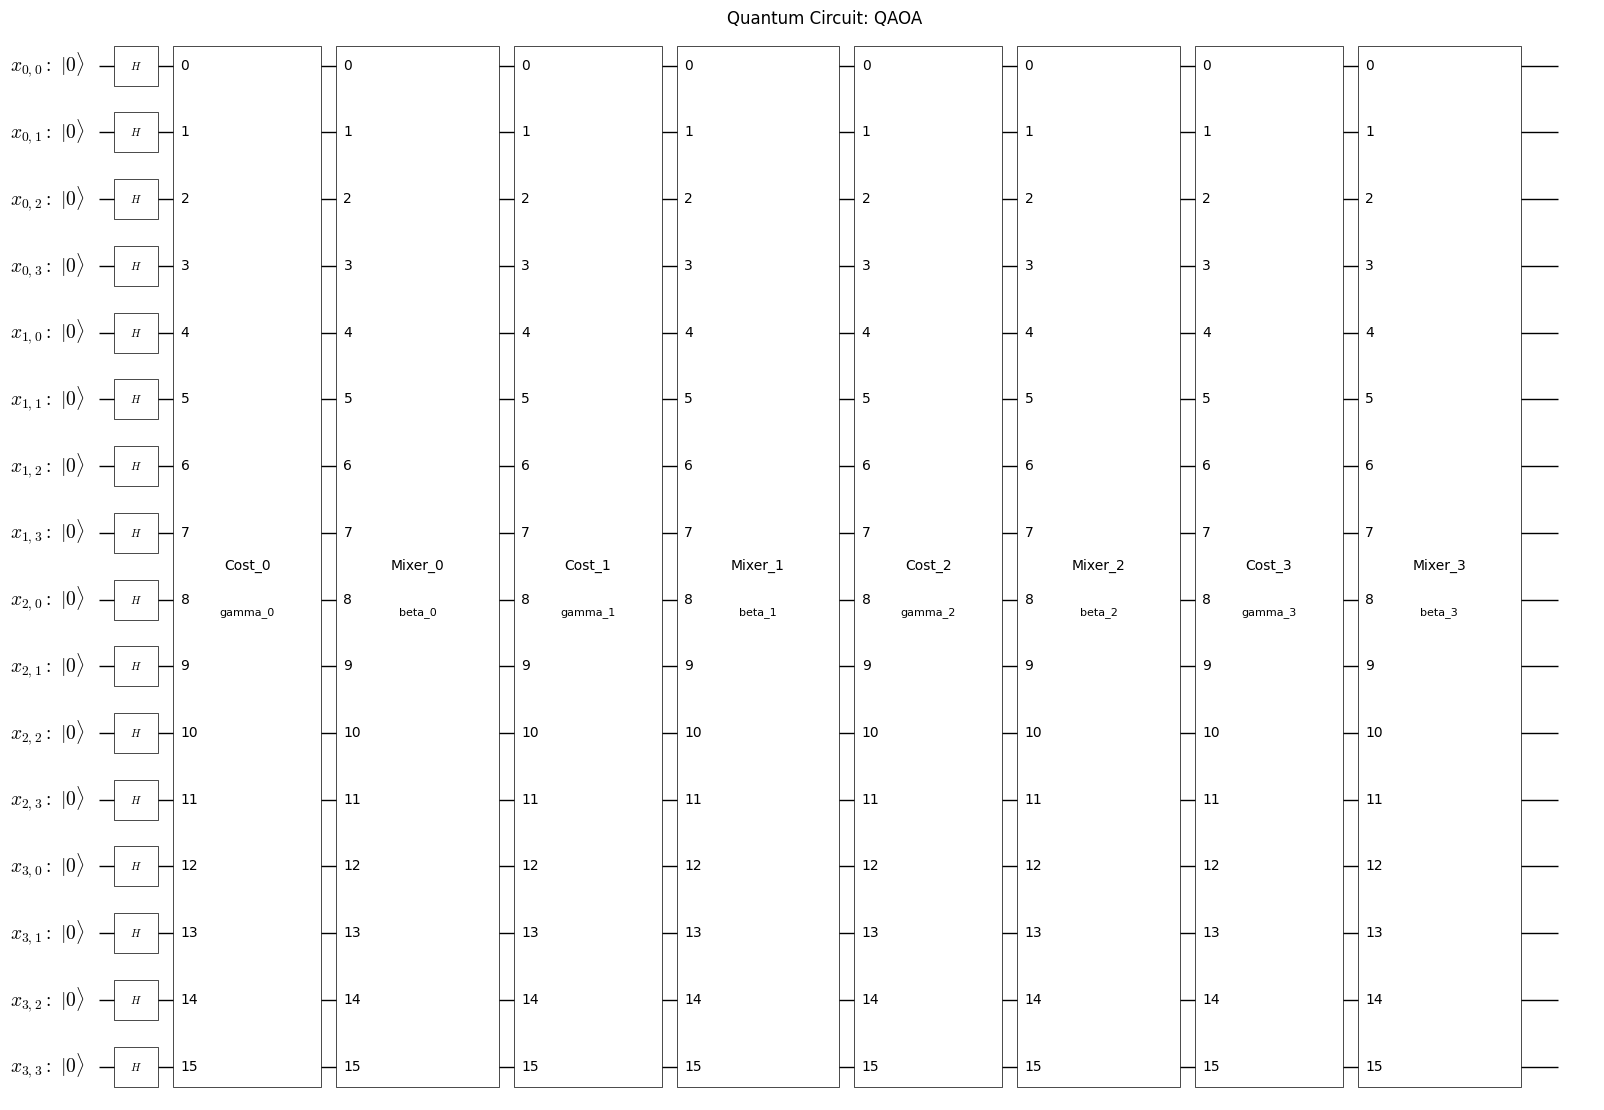

In [8]:
plot_quantum_circuit(qaoa_circuit)

## 取得した QAOA 回路とハミルトニアンを Quri-Parts 向けに変換
次に、Qamomile によって生成された回路とハミルトニアンを Quri-Parts 互換のオブジェクトに変換します。これにより、Quri-Parts をシミュレーションフレームワークとして用いて量子アルゴリズムを実行できるようになります。

In [9]:
qp_transpiler = QuriPartsTranspiler()
qp_circuit = qp_transpiler.transpile_circuit(qaoa_circuit)
qp_cost = qp_transpiler.transpile_hamiltonian(qaoa_cost)

In [10]:
cb_state = quantum_state(qaoa_circuit.num_qubits, bits=0)
parametric_state = apply_circuit(qp_circuit, cb_state)

## QAOA の実行

In [11]:
estimator = create_qulacs_vector_parametric_estimator()

cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_cost, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost

def create_initial_param(p: int) -> list[float]:
    res = []
    # ベータ
    for i in range(p):
        res.append(np.pi/(2 * (p - i)))
    # ガンマ
    for i in range(p):
        res.append(np.pi/(2 * (i + 1)))
    return res


param_result = opt.minimize(cost_fn,create_initial_param(p), method="COBYLA", options={"maxiter": 1000})
param_result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 132.8076916309783
       x: [ 2.159e-01  1.564e+00  2.289e-01  2.674e+00  1.505e+00
            3.661e-01  3.698e-01 -2.705e-01]
    nfev: 752
   maxcv: 0.0

## 結果の可視化

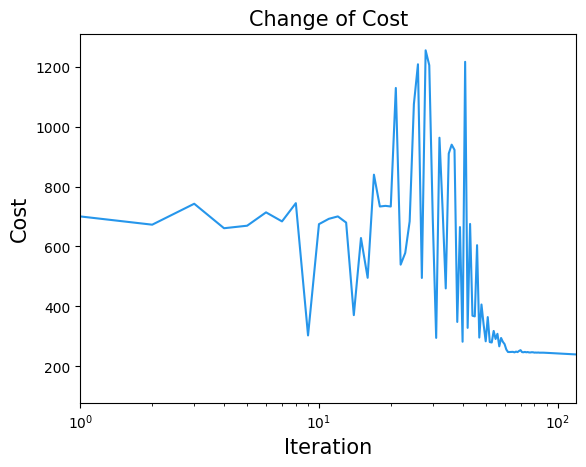

In [12]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, 120)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

In [13]:
sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_circuit.bind_parameters(param_result.x)
qp_result = sampler(bounded_circuit, 10000)

最後に、サンプリングされた結果を元の巡回セールスマン問題の解に変換します。

In [14]:
sampleset = qaoa_converter.decode(qp_transpiler, (qp_result, qaoa_circuit.num_qubits))

## 結果の評価
Finally, we display the sampled results using graphs to visualize the solutions obtained from the algorithm. Please note that in some cases, a feasible solution may not be achieved.

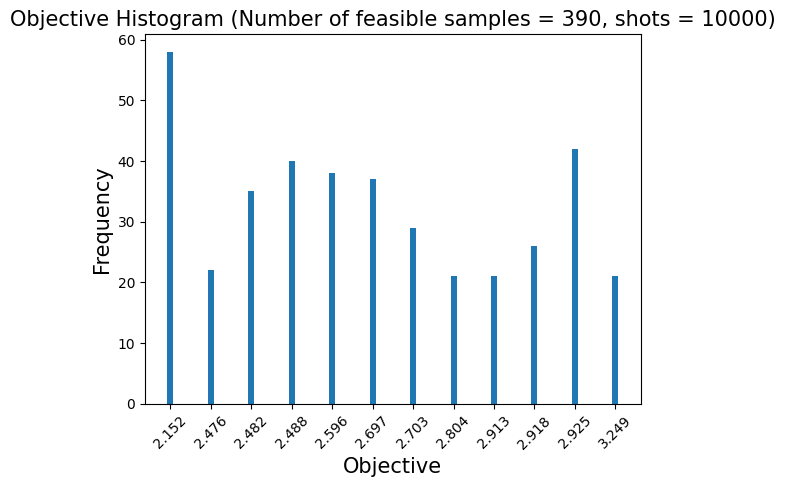

In [15]:
def show_energy_histogram(sampleset: ommx.v1.SampleSet):
    # 各エネルギー値の頻度を保存するための defaultdict を作成する
    d = defaultdict(int)

    feasibles = sampleset.feasible
    for entry in sampleset.raw.objectives.entries:
        feas_ids = [i for i in entry.ids if feasibles[i]]
        if len(feas_ids) == 0:
            continue
        e = round(entry.value, ndigits=3)
        d[e] = len(feas_ids)

    # エネルギー値とそれに対応する頻度を抽出
    energies = list(d.keys())
    num_occurrences = list(d.values())

    # 総ショット数を計算
    shots = len(sampleset.sample_ids)

    # エネルギー値と出現数をソートして順序を整える
    sorted_pairs = sorted(zip(energies, num_occurrences))
    energies, num_occurrences = zip(*sorted_pairs)
    # 均等間隔の棒でヒストグラムをプロット
    plt.bar(range(len(energies)), num_occurrences, width=0.15, align='center')
    plt.title("Objective Histogram (Number of feasible samples = {0}, shots = {1})".format(sum(num_occurrences), shots), fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.xlabel("Objective", fontsize=15)
    plt.xticks(range(len(energies)), np.round(energies,3), rotation=45) 
    plt.show()

show_energy_histogram(sampleset)

## 解のプロット
サンプルセットから最適解を取得し、対応する巡回ルートを表示します。

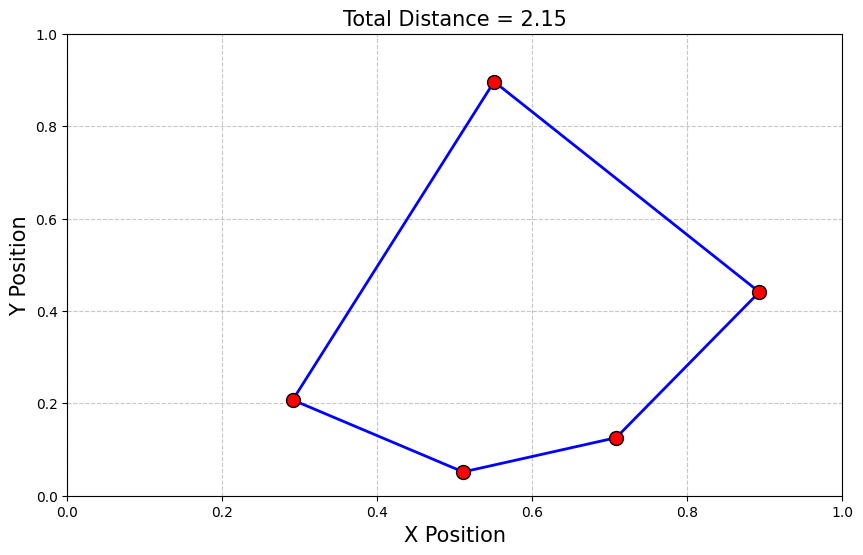

In [16]:
def plot_tsp(sampleset: ommx.v1.SampleSet, x_pos, y_pos, N):
    # 最良の実行可能なサンプルを抽出
    best_sample = sampleset.best_feasible_unrelaxed()
    d = {k: v for k, v in best_sample.extract_decision_variables("x").items() if v == 1 }
    
    # 巡回経路を決定
    route = [N - 1] * (N + 1)
    for key in d.keys():
        route[key[1] + 1] = key[0]
    
    # 総距離を計算し，経路をプロット
    total_distance = 0
    plt.figure(figsize=(10, 6))
    
    for i in range(len(route) - 1):
        x_coords = [x_pos[route[i]], x_pos[route[i + 1]]]
        y_coords = [y_pos[route[i]], y_pos[route[i + 1]]]
        plt.plot(x_coords, y_coords, 'b-', linewidth=2)
        total_distance += np.sqrt((x_coords[0] - x_coords[1]) ** 2 + (y_coords[0] - y_coords[1]) ** 2)
    
    # ノードをプロット
    plt.scatter(x_pos, y_pos, c='red', s=100, edgecolors='k', zorder=3)
    
    # プロットの設定
    plt.title(f"Total Distance = {total_distance:.2f}", fontsize=15)
    plt.xlabel("X Position", fontsize=15)
    plt.ylabel("Y Position", fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # プロットの表示
    plt.show()
        
plot_tsp(sampleset, x_pos, y_pos, N)